In [25]:
import numpy as np
import cv2 as cv
from funcs import *

In [26]:
TRAIN = 'C:/Users/jalfr/OneDrive/Desktop/MASP/Code/Test/image_detection/image-feature-recognition/img/WEB_JM_MASP_00113_01.jpg'
QUERY = 'C:/Users/jalfr/OneDrive/Desktop/MASP/Code/Test/image_detection/image-feature-recognition/img/teste.jpeg'

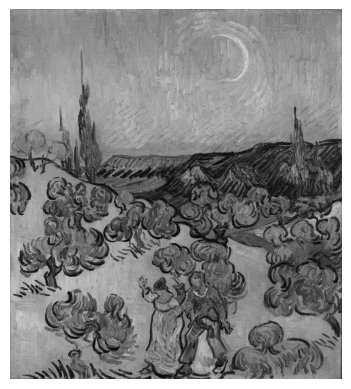

In [27]:
train = cv_grayread(TRAIN)

train_height, train_width = train.shape

cv_imshow(train)

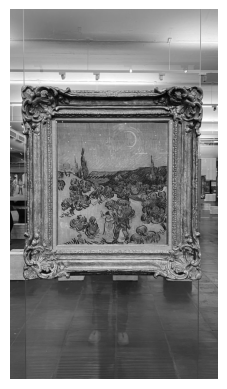

In [28]:
query = cv_grayread(QUERY)

query_height, query_width = query.shape

cv_imshow(query)

In [29]:
sift = cv.SIFT_create()

train_keypoints, train_descriptors = sift.detectAndCompute(train, None)
query_keypoints, query_descriptors = sift.detectAndCompute(query, None)

In [30]:
matcher = cv.FlannBasedMatcher()

matches = matcher.knnMatch(query_descriptors, train_descriptors, k=2)

In [31]:
# A binary mask that we will need to
# avoid drawing the discarded matches.
matches_mask = []

# A list of the non-discarded matches.
good_matches = []

# Because we passed k=2 to knnMatch,
# each element is a tuple of size two.
for first, second in matches:

    # If the first distance is above 80% of
    # the second distance, both are discarded.
    if first.distance > 0.8 * second.distance:
        matches_mask.append((0, 0))

    # Otherwise, only the second is discarded.
    else:
        matches_mask.append((1, 0))
        good_matches.append(first)

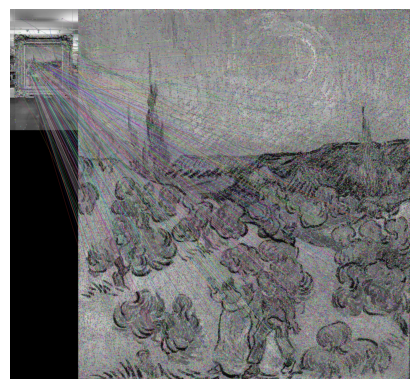

In [32]:
matches_output = cv.drawMatchesKnn(query, query_keypoints, train, train_keypoints, matches, None, matchesMask=matches_mask)

cv_imshow(matches_output)

In [33]:
pose_src = []
pose_dst = []

for first in good_matches:
    pose_src.append(train_keypoints[first.trainIdx].pt)
    pose_dst.append(query_keypoints[first.queryIdx].pt)

# The findHomography method expects points
# given as NumPy arrays, so we need this.
pose_src = np.array(pose_src)
pose_dst = np.array(pose_dst)

# There are two outputs: the homography and
# a binary mask that indicates which matches
# are outliers with respect to it. We are
# not interested in this mask, so we use _.
H, _ = cv.findHomography(pose_src, pose_dst, cv.RANSAC)

In [34]:
# The rectangle points must use the (x, y) ordering,
# because OpenCV really loves to make you confused.
rectangle_src = [
    (0, 0),
    (0, train_height),
    (train_width, train_height),
    (train_width, 0),
]

# OpenCV is also picky. The method expects a NumPy
# floating-point array and, due to some weirdness
# of the Python bindings, it also needs an extra
# dimension. This is why we wrap it in an extra [].
rectangle_src = np.array([rectangle_src], dtype=float)

# In a perfect world, this is the only line we
# would need. Alas, we sadly do not live in one.
rectangle_dst = cv.perspectiveTransform(rectangle_src, H)

# Reversing the pickiness. We use [0] to remove
# the extra dimension and a combination of round
# and astype to convert the points to integers.
rectangle_dst = rectangle_dst[0].round().astype(int)

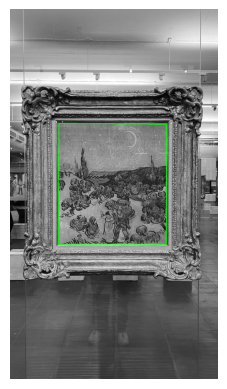

In [35]:
color = (0, 255, 0)

thickness = 2

rectangle_output = cv.cvtColor(query, cv.COLOR_GRAY2BGR)

cv.line(rectangle_output, rectangle_dst[0], rectangle_dst[1], color, thickness)
cv.line(rectangle_output, rectangle_dst[1], rectangle_dst[2], color, thickness)
cv.line(rectangle_output, rectangle_dst[2], rectangle_dst[3], color, thickness)
cv.line(rectangle_output, rectangle_dst[3], rectangle_dst[0], color, thickness)

cv_imshow(rectangle_output)

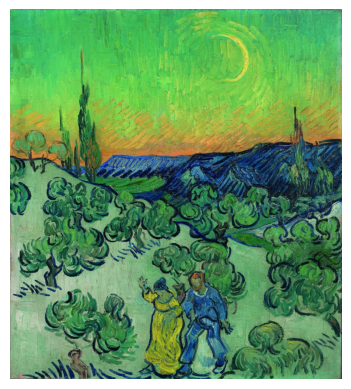

In [36]:
color_train = cv_imread(TRAIN)

cv_imshow(color_train)

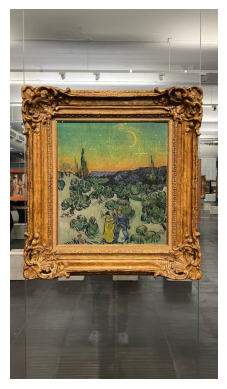

In [37]:
color_query = cv_imread(QUERY)

cv_imshow(color_query)

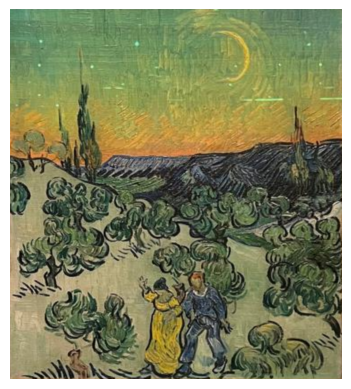

In [38]:
# What we want is to invert the effect of the homography.
# This can be achieved by literally inverting the matrix.

H1 = np.linalg.inv(H)

# Parameter 1: the image you want to transform.
#
# Parameter 2: the homography you want to apply.
#
# Parameter 3: the size of the output image. The
#              crop is from (0, 0) to this size.

train_size = (train_width, train_height)

output1 = cv.warpPerspective(color_query, H1, train_size)

cv_imshow(output1)